In [1]:
import numpy as np
import math

from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import svd_flip, randomized_svd

from scipy.sparse.linalg import svds
from scipy.misc import imfilter
import scipy.ndimage as ndi

import scipy.io

from heapq import heappush, heappop

from random import uniform

import matplotlib
import matplotlib.pyplot as plt


from pprint import pprint

In [2]:
def svd_wrapper(Y, k, method='svds'):
    if method is 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]        
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method is 'random':
        Ut, St, Vt = randomized_svd(Y, k)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

In [3]:
class WeightedReservoirSampler:
    def __init__(self, reservoir_size):
        self.m = reservoir_size

        self.reservoir = []
        
    def add(self, weight, data):
        rw = uniform(0.0,1.0)**(1.0/weight)
        if(len(self.reservoir)< self.m):
            heappush(self.reservoir, (rw,data))
        elif rw > self.reservoir[0][0]:
            heappop(self.reservoir)
            heappush(self.reservoir, (rw,data))
        #print(len(self.reservoir))

In [4]:
class MDTrSampler:
    def __init__(self, n_atoms, n_dim = 2, conv_size = 50, n_samples=1000, batch_size=100, manifold_size=64):
        self.n_dim = n_dim
        self.conv_size = conv_size
        self.n_atoms = n_atoms
        self.batch_size = batch_size
        self.l = manifold_size
        self.n_samples = n_samples
        self.bq = np.zeros((batch_size,n_atoms,3)) # batch queue
        self.total_samples = 0
        self.bq_index = 0
        self.Btp = np.zeros((n_atoms*3,self.l))
        self.strm_smplr = WeightedReservoirSampler(n_samples)
        self.last_Vt = None
    
    def traj_char(self, c, s):
        x = c.shape[0]
        # scaled data <-- not so much meaningful as we're doing l2 normalization later
        ps = np.mat(c[:,:self.n_dim]) * np.mat(np.diag(s[:self.n_dim]))
        # gradient or changes of each data point
        psd = ps[0:(x-1),:self.n_dim] - ps[1:x, :self.n_dim];
        
        # convoluted gradient --> smoothed gradient
        psdm = ndi.convolve(psd, np.ones((self.conv_size,2))/self.conv_size*2);
        # L2 normalized smoothed gradients --> now we focus on the angle of gradient only as atoms may move different speed 
        npsdm = np.divide(psdm, np.mat(np.sum(np.abs(psdm)**2,axis=-1)**(1./2)).T  * np.mat(np.ones((1,n_dim))))
        # Angle smoothing with the assumption that the overall angle can not be radically changed
        nmpsdm = ndi.convolve(npsdm, np.ones((self.conv_size,2))/self.conv_size*2);
        # Smoothed angle changes (accelerations)
        psdd = nmpsdm[0:(x-2)] - nmpsdm[1:(x-1)]
        # results for gradient of changes
        psdu = np.sum(abs(psd),axis=1)
        # results of smoothed normalized acceleration
        psddu = np.sum(abs(psdd),axis=1)
        prob_dist = (abs(psddu) / np.sum(psddu))
        return nmpsdm, psddu, prob_dist
    
    def strmML(self, t2):
        n_t = t2.shape[1]
        Ct = np.concatenate( (self.Btp, t2), axis = 1)
        Ct = Ct[:, ~(Ct==0).all(0)]

        Ut, St, Vt = svd_wrapper(Ct, self.l) #SVD_l(matrix)
        Ut_l = Ut[:, :self.l]
        St_l = St[:self.l] - St[self.l-1] # to be adaptive, added singular substraction
        Vt_l = Vt[:self.l, -n_t:]
        self.Btp= np.dot(Ut_l, np.diag(St_l))

        return Ut_l, St_l, Vt_l
    
    def batch_sampling(self, trace):
        (x,y,z) = trace.shape
        self.sampling_rate = float(self.n_samples) / float(x)
        t2 = trace.reshape((x, y*z),order='C')
        c,s,v = svd_wrapper(t2, 2, method='random')
        nmpsdm, psddu, prob_dist = self.traj_char(c,s) 
        total = 10**-10 + prob_dist[0]
        sampling_entries = int(x * self.sampling_rate)
        target = np.zeros((sampling_entries, y, z))
        time_stamps = np.zeros(sampling_entries)
        #output initialization: the first one should be added always
        target[0,:,:] = trace[0,:,:]
        time_stamps[0] = 0;
        t_idx = 1;
        for i in range(2,x):
            total = total + prob_dist[i-2];
            if(total > 1 / float(sampling_entries - 1)):
                target[t_idx,:,:] = trace[i,:,:]
                time_stamps[t_idx] = i
                total = total - 1 / float(sampling_entries-1);
                t_idx = t_idx + 1;
        return target, time_stamps
    
    
    def adaptive_sampling_update(self):
        t2 = self.bq[0:self.bq_index,:,:].reshape((self.bq_index, self.n_atoms*z),order='C').T
        Ut, s, VTt = self.strmML(t2)
        if self.last_Vt is None: # for the first time
            c = VTt.T
            self.strm_smplr.add(10**10,[0, self.bq[0,:,:]])
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(2,self.bq_index):
                self.strm_smplr.add(psddu[i-2], [sidx+i, self.bq[i,:,:]])
        else:
            c =  np.concatenate( (self.last_Vt, VTt.T), axis = 0)
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(0,self.bq_index):
                self.strm_smplr.add(psddu[i], [sidx+i, self.bq[i,:,:]])
                
        self.last_Vt = VTt.T[-2:,:] # for last two to start compare against
        
        

    def adaptive_sampling_step(self, dataframe_t):
        self.total_samples = self.total_samples + 1
        self.bq[self.bq_index] = dataframe_t
        self.bq_index = self.bq_index+1
        if self.bq_index == (self.batch_size):
            self.adaptive_sampling_update()
            self.bq_index = 0
        


In [5]:
mat= scipy.io.loadmat('../data/collision_0-5k.mat')

In [6]:
trace = mat['trace']
(x,y,z) = trace.shape
t2 = trace.reshape((x, y*z),order='C')

In [7]:
Ut, St, VTt = svd_wrapper(t2, 2, method='random')

In [8]:
c = Ut
s = St

In [9]:
n_dim=2
step=1000
c.shape

(5000, 2)

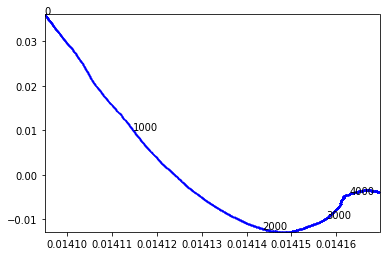

In [11]:
fig, ax = plt.subplots()
ax.scatter(c[:,0],c[:,1], marker=".", c='b', s=0.5)
ax.set_xlim(min(c[:,0]), max(c[:,0]))
ax.set_ylim(min(c[:,1]), max(c[:,1]))
for i in range(0,x,step):
    ax.annotate(str(i),(c[i,0],c[i,1]))
plt.show()

In [12]:
mds = MDTrSampler(y, n_dim = 2, conv_size = 50, n_samples=100, batch_size=100, manifold_size=64)

nmpsdm, psddu, prob_dist = mds.traj_char(c,s)     

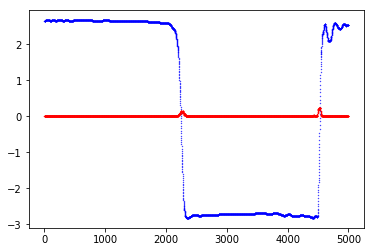

In [13]:
fig_b, ax_b = plt.subplots()
ax_b.scatter(range(0,nmpsdm.shape[0]),nmpsdm[:,0], marker=".", c="b", s=0.5)
ax_b.scatter(range(0,psddu.shape[0]),psddu[:],marker="x", c="r", s=0.2)
plt.show()

In [14]:
sampling_rate = 0.005
target, time_stamps = mds.batch_sampling(trace)

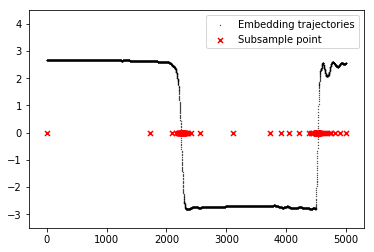

In [36]:
fig_c, ax_c = plt.subplots()
ax_c.scatter(range(0,nmpsdm.shape[0]),nmpsdm[:,0], marker=".", c="k", s=0.4, label='Embedding trajectories')
ax_c.scatter(time_stamps, np.zeros(time_stamps.shape),marker="x",c="r", s=25.0, label='Subsample point')
plt.legend(loc="upper right")
plt.ylim(-3.5, 4.5)
plt.savefig("pre-print-MDtrj-smpl.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [18]:
mds2 = MDTrSampler(y, n_dim = 2, conv_size = 50, n_samples=64, batch_size=512, manifold_size=256)
for i in range(x):
    mds2.adaptive_sampling_step(trace[i,:,:])


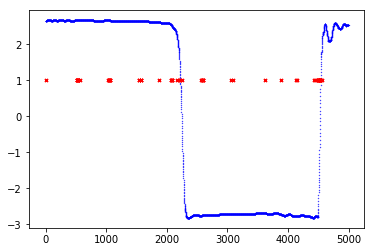

In [20]:
adaptive_samples = sorted([ mds2.strm_smplr.reservoir[i][1][0] for i in range(64)])
fig_d, ax_d = plt.subplots()
ax_d.scatter(range(0,nmpsdm.shape[0]),nmpsdm[:,0], marker=".", c="b", s=0.5)
ax_d.scatter(adaptive_samples, np.ones(len(adaptive_samples)),marker="x",c="r", s=10.0)
plt.show()

In [21]:
pprint(adaptive_samples)

[0,
 514,
 516,
 517,
 522,
 533,
 535,
 538,
 539,
 540,
 558,
 1025,
 1038,
 1045,
 1046,
 1048,
 1056,
 1059,
 1068,
 1537,
 1544,
 1570,
 1572,
 1576,
 1871,
 2060,
 2067,
 2077,
 2084,
 2090,
 2171,
 2192,
 2217,
 2224,
 2250,
 2560,
 2572,
 2577,
 2591,
 2596,
 2598,
 3064,
 3092,
 3622,
 3880,
 4129,
 4145,
 4435,
 4442,
 4486,
 4493,
 4498,
 4501,
 4505,
 4512,
 4513,
 4518,
 4524,
 4528,
 4530,
 4533,
 4535,
 4541,
 4555]
